In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

import matplotlib as mpl
mpl.rc('figure', figsize=(10, 5))
plt.style.use('seaborn-bright')


## Calcul de déformations : modèle de Moggi

$$
\mathbf u = \Delta p (1-\nu)\frac{r_s^3}{G} \frac{\mathbf x - \mathbf x_s}{|| \mathbf x - \mathbf x_s ||^{3}}
$$

$\mathbf u$ le déplacement observé en $\mathbf x$ pour une source sphérique de centre $\mathbf x_s$ et de rayon $r_s$ affichant une surpression $\Delta p$. $\nu$ le coefficient de Poisson et $G$ le module de cisaillement du milieu encaissant.

In [6]:

# Définition des constantes du milieu
G = 1. # module de cisaillement
nu = 0.25 # coefficient de Poisson

# Domaine d'étude
L = 10. 
H = 1.
N = 100 # discrétisation
X = np.linspace(0, L, N)
Y = np.linspace(0, L, N)
XX,YY = np.meshgrid(X,Y)

# Définition de la chambre
a = 0.01 # rayon 
xs,ys,zs = [L/3,L/3,H/2] # position 
dp = 1. # surpression

# Calcul de la déformation en surface
s = dp*(1-nu)*a**3/G 

R = np.sqrt((XX-xs)**2+(YY-ys)**2+zs**2)
R_prof = np.sqrt((XX-xs)**2+(YY-ys)**2+1e-12)
iR3 = 1/R**3

uz = s*zs*iR3 
ur = s*np.sqrt((XX-xs)**2+(YY-ys)**2)*iR3

ux = ur*(XX-xs)/R_prof
uy = ur*(YY-ys)/R_prof

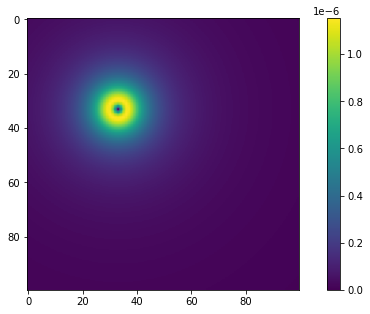

In [7]:
plt.imshow(ur)
plt.colorbar()

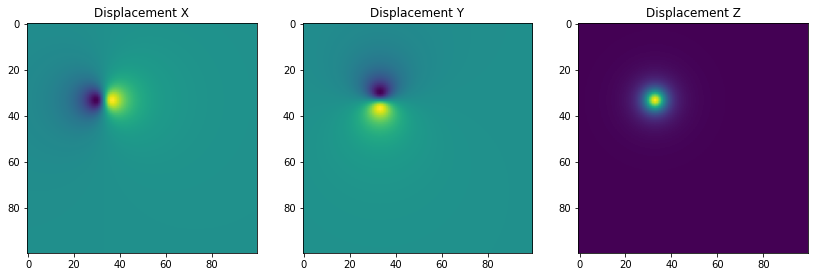

In [8]:
# Plot de la déformation 
fig,axes = plt.subplots(1, 3, figsize=(14,6))
im = axes[0].imshow(ux)
axes[0].set_title("Displacement X")
im = axes[1].imshow(uy)
axes[1].set_title("Displacement Y")
im = axes[2].imshow(uz)
axes[2].set_title("Displacement Z")
plt.show()

## Tirage aléatoire de chambres dans une zone magmatique cylindrique

In [2]:
# Tirage aléatoire des chambres

# On tire des chambres sphériques contenues dans un cylindre de hauteur H de profondeur Z et de rayon R
H_magma_body = 1e3
Z_magma_body = 1e3
R_magma_body = 1e3

# Rayon des chambres
# # Hyp 1 : tq suivant une loi exponentielle d'esperance R
# R_mean_magma_chamber = 50. 
# Hyp 2 : tq suivant une loi normale d'esperance R et d'écart type SIGMA
R_mean_magma_chamber = 30. 
SIGMA_magma_chamber = 10.

# On tire des chambres jusqu'à que le volume de chambre soit X fois le volume du cylindre
X_fraction_volume = 0.1
volume_cible = X_fraction_volume*np.pi*R_magma_body**2*H_magma_body

class MagmaChamber : 
    def __init__(self,x,y,z,r):
        self.x = x 
        self.y = y 
        self.z = z 
        self.radius = r 
    def __str__(self):
        return f"{self.radius:.1f}km at ({self.x:.1f},{self.y:.1f},{self.z:.1f})"
    def distance(self, mc_b):
        return np.sqrt((self.x-mc_b.x)**2+(self.y-mc_b.y)**2+(self.z-mc_b.z)**2)

def check_for_collision(mc1,mc2,mc3):
    """Check if edge (mc1,mc2) is crossing mc3"""
    
    # si z3 non compris dans [z1,z2] ou r3 non compris dans [r1,r2] : pas de collision possible
    z_min = min(mc1.z,mc2.z)
    z_max = max(mc1.z,mc2.z)
    if (mc3.z < min(mc1.z,mc2.z)) or (mc3.z > max(mc1.z,mc2.z)) : return False 
    r1,r2,r3 = mc1.x**2+mc1.y**2,mc2.x**2+mc2.y**2,mc3.x**2+mc3.y**2
    if (r3 < min(r1,r2)) or (r3 > max(r1,r2)) : return False 
    
    # Paramètres de la ligne mc1-mc2
    line_vector = np.array([mc2.x - mc1.x, mc2.y - mc1.y, mc2.z - mc1.z])
    line_point = np.array([mc1.x, mc1.y, mc1.z])

    # Paramètres de la sphère
    sphere_center = np.array([mc3.x, mc3.y, mc3.z])

    # Calcul du vecteur entre le centre de la sphère et le point sur la ligne le plus proche
    nearest_point = line_point + np.dot(line_vector, sphere_center - line_point) / np.dot(line_vector, line_vector) * line_vector
    distance = np.linalg.norm(nearest_point - sphere_center)

    # Vérification de l'intersection
    if distance <= mc3.radius:
        return True
    else:
        return False
        
magma_chambers = []
total_mc_vol = 0. 
while total_mc_vol < volume_cible :
    
    # tirage du centre de la chambre
    z = np.random.uniform(Z_magma_body, Z_magma_body+H_magma_body)
    r_pos = np.random.uniform(0., R_magma_body)
    theta = np.random.uniform(0, 2*np.pi)
    
    x = r_pos*np.cos(theta)
    y = r_pos*np.sin(theta)
    
    # tirage du rayon de la chambre
    # r = np.random.exponential(scale=R_mean_magma_chamber)
    # r = np.random.normal(R_mean_magma_chamber, SIGMA_magma_chamber)
    r = 50. # chambres de 50m de diamètre
    
    # check that within the cylinder
    if r+r_pos > R_magma_body:
        continue 
    
    if ((z-Z_magma_body < r) or (Z_magma_body+H_magma_body-z < r)):
        continue
    
    # check that does not intersect with other chambers
    for chamber in magma_chambers:
        if np.sqrt((chamber.x-x)**2+(chamber.y-y)**2+(chamber.z-z)**2) < chamber.radius + r:
            continue
        
    # checks passed
    magma_chambers.append(MagmaChamber(x,y,z,r))
    total_mc_vol += 4/3*np.pi*r**3
    
print(len(magma_chambers))

601


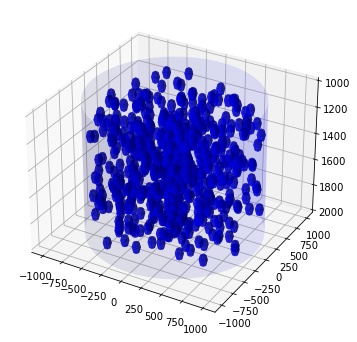

In [3]:
def plot_sphere(ax, center, radius, text):
    phi, theta = np.mgrid[0.0:2.0*np.pi:10j, 0.0:np.pi:5j]
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)
    ax.plot_surface(x, y, z, color='b',  shade=True, alpha=0.7)
    # ax.text(x, y, z, text, color='red', fontsize=8, ha='center', va='center')
    
def plot_cylinder(ax, center, radius, height):
    phi = np.linspace(0, 2*np.pi, 100)
    z = np.linspace(0, height, 50)
    Z, Phi = np.meshgrid(z, phi)
    X = center[0] + radius * np.cos(Phi)
    Y = center[1] + radius * np.sin(Phi)
    ax.plot_surface(X, Y, Z + center[2], color='b', alpha=0.1)

    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

for i,mc in enumerate(magma_chambers):
    plot_sphere(ax, [mc.x, mc.y,mc.z], mc.radius, i+1)
    
plot_cylinder(ax, [0,0,Z_magma_body], R_magma_body, H_magma_body)
    
# ax.set_box_aspect([np.ptp(coord) for coord in zip(*[s[0] for s in spheres])])

ax.invert_zaxis()
plt.show()

In [16]:
# Création d'un graph

mc_graph = nx.Graph()

# 0. ajout de la chambre source
mc_graph.add_node(0, radius=-1, center_coord=np.array([-1,-1,-1]))
    
# 1. ajout des noeuds
for i,mc in enumerate(magma_chambers):
    mc_graph.add_node(i+1, radius=mc.radius, center_coord=np.array([mc.x,mc.y,mc.z]))

# 2. ajout des arrêtes
for i,mc1 in enumerate(magma_chambers):
    for j,mc2 in enumerate(magma_chambers):
        if i == j: continue 
        valid = True
        for k,mc3 in enumerate(magma_chambers):
            if (i==k) or (j==k): continue
            if check_for_collision(mc1,mc2,mc3): 
                valid = False
                break
        if valid : mc_graph.add_edge(i+1, j+1, distance=mc1.distance(mc2))

In [5]:
def draw_graph(G, node_size_comp, edge_width_comp, node_size_factor=400, edge_width_factor=4):   
    
    seed = 13648
    pos = nx.spring_layout(G, seed=seed)
    
    node_sizes = [G.nodes[node][node_size_comp]*node_size_factor for node in G.nodes]
    node_sizes[0] = 5*node_size_factor
    edge_sizes = [G.edges[edge][edge_width_comp]*edge_width_factor for edge in G.edges]
    
    fig,ax = plt.subplots(figsize=(8,8))

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
    nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        width=edge_sizes,
    )
    
    nx.draw_networkx_labels(G, pos, font_color="w")

    ax.set_axis_off()
    ax.set_title(f"Node size = {node_size_comp} ; egde width = {edge_width_comp}")
    fig.patch.set_facecolor('white')
    return fig,ax
    
# fig,ax = draw_graph(mc_graph, "radius", "distance", node_size_factor=50, edge_width_factor=1e-3)
# plt.show()

In [17]:
# Calcul des compressibilités (absolues : V*compressibilité) et des conductivitées

G = 10e9 # 10GPa : granite
R_conduct = 1. # rayon des conduits = 50m
mu_magma = 100 # 100 Pa.s : magma basaltique 1500K

for node in mc_graph.nodes:
    
    if mc_graph.nodes[node]["radius"] == -1 : continue # source
    
    # mc_graph.nodes[node]["compressibility"] = 4/3*np.pi*mc_graph.nodes[node]["radius"]**3 * 3/(4*G) 
    mc_graph.nodes[node]["compressibility"] = 1e-5
    
    for node2 in mc_graph.nodes:
        if mc_graph.nodes[node2]["radius"] == -1 : continue 
        try : 
            if mc_graph[node][node2]["distance"] < 500. :
                mc_graph[node][node2]["conductivity"] = 1e-5
                
            # mc_graph[node][node2]["conductivity"] = np.pi*R_conduct**4/(8*mu_magma*mc_graph[node][node2]["distance"])
            
        except:
            pass # nodes not connected 

# Connexion de la chambre la plus profonde à la source
depths = np.array([center[2] for center in nx.get_node_attributes(mc_graph, "center_coord").values()])
radius = np.array(list(nx.get_node_attributes(mc_graph, "radius").values()))
depths_max = depths + radius
i_max_depth = depths_max.argmax()

distance_to_source = Z_magma_body+H_magma_body-depths_max.max()
# mc_graph.add_edge(i_max_depth, 0, conductivity=np.pi*R_conduct**4/(8*mu_magma*distance_to_source))
mc_graph.add_edge(i_max_depth, 0, conductivity=1e-5)

In [22]:
nb_edges = mc_graph.number_of_edges()
nb_nodes = mc_graph.number_of_nodes()
print(f"Nombre de conduits = {nb_edges} ({nb_edges/nb_nodes:.0f} edge per node)")

Nombre de conduits = 82868 (138 edge per node)


In [23]:
# Retirer les arrêtes pour lesquelles la conductivité n'est pas définie
edges_to_remove = [(u, v) for u, v, data in mc_graph.edges(data=True) if 'conductivity' not in data]
mc_graph.remove_edges_from(edges_to_remove)

In [24]:
nb_edges = mc_graph.number_of_edges()
nb_nodes = mc_graph.number_of_nodes()
print(f"Nombre de conduits = {nb_edges} ({nb_edges/nb_nodes:.0f} edge per node)")

Nombre de conduits = 18223 (30 edge per node)


In [25]:
# Répartition des distances
distances = list(nx.get_edge_attributes(mc_graph, "distance").values())
conductivity = np.array(list(nx.get_edge_attributes(mc_graph, "conductivity").values()))
compressibility = np.array(list(nx.get_node_attributes(mc_graph, "compressibility").values()))

print(f"Mean conductivity = {conductivity.mean():.2e}")
print(f"Mean compressibility = {compressibility.mean():.2e}")
print(f"Characteritic time = {compressibility.mean()/conductivity.mean():.2e}")

Mean conductivity = 1.00e-05
Mean compressibility = 1.00e-05
Characteritic time = 1.00e+00


[]

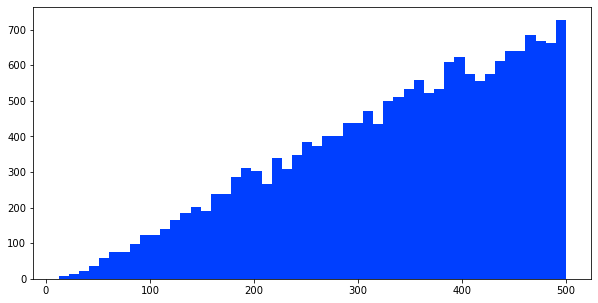

In [26]:
plt.hist(distances, 50)
plt.plot()

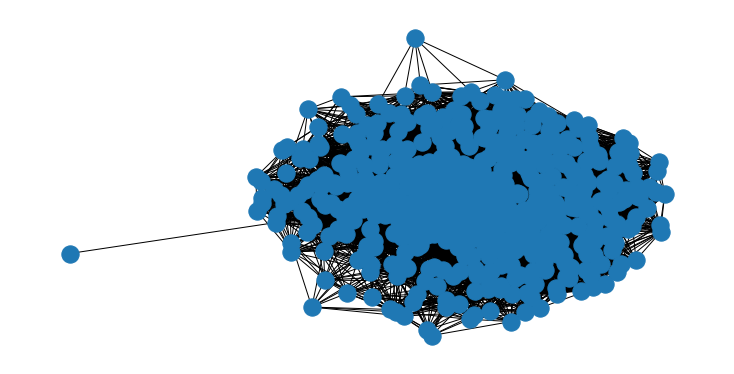

In [27]:
nx.draw(mc_graph)

# fig,ax = draw_graph(mc_graph, "radius", "conductivity", node_size_factor=10, edge_width_factor=1e5)
# plt.show()

# Calcul de la réaction du système à une surpression

Si conductivité égales partout : système répond 

In [28]:
from pressure_timeseries import compute_pressure_time_serie

DELTA_P = 1e7 # 10 MPa
def source(t, t_s=0.): return DELTA_P if t >= t_s else 0

tmax = 1e3 # 1 an
p0 = np.zeros(len(mc_graph)-1)

p = compute_pressure_time_serie(mc_graph, source, tmax, p0)

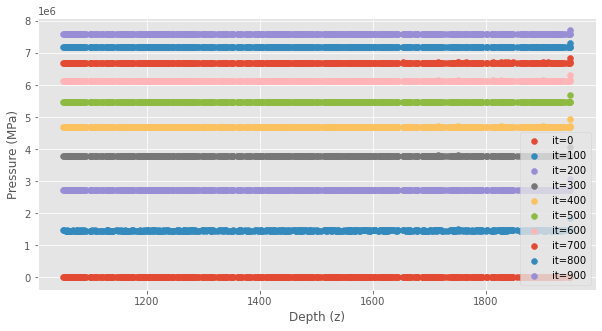

In [46]:
# plotter la pression à un temps t en fonction de la profondeur de la chambre

coords = np.array(list(nx.get_node_attributes(mc_graph, "center_coord").values()))
depths = coords[1:,2]

for it in [100*i for i in range(10)]:
    plt.scatter(depths, p[it,:],label=f"it={it}")
plt.legend()
plt.xlabel("Depth (z)")
plt.ylabel("Pressure (MPa)")
plt.show()

[]

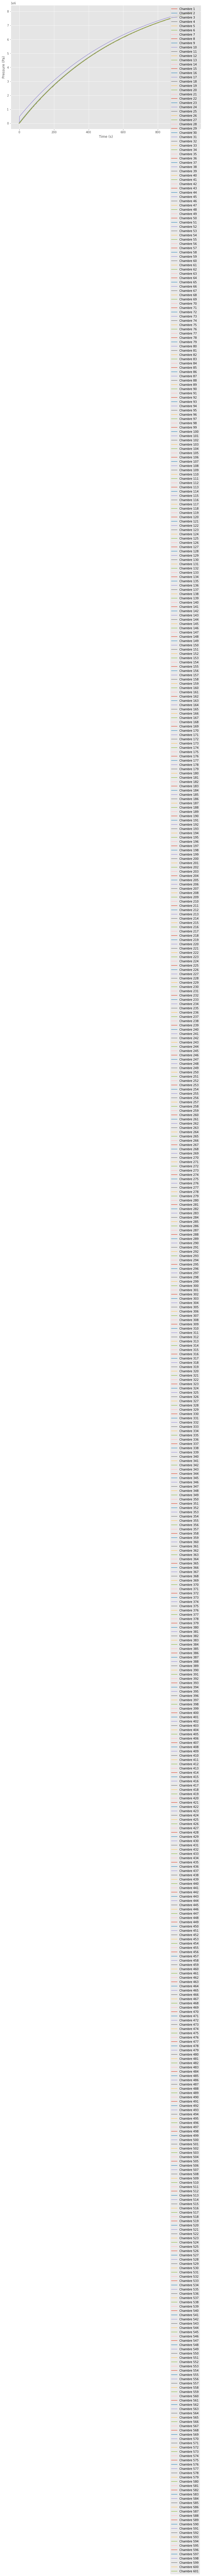

In [29]:

# Tracé des pressions dans les chambres au cours du temps 
t_space = np.linspace(0, tmax, p.shape[0])
# plt.plot(t_space, [source(t_) for t_ in t_space], label="Source", color="k", ls=":")

fig,ax = plt.subplots(figsize=(12,8))

for i in range(len(mc_graph)-1):
    ax.plot(t_space, p[:,i], label=f"Chambre {i+1}")
    
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Pa)")
plt.legend()
plt.plot()

# Calcul des déformations en surface causées par les surpressions dans les chambres

In [143]:
# Calcul des déformations causées par un ensemble de chambres 
# On calcul la déformation engendrée en surface pour chaque chambre et on somme

L = 5e3 
N_space = 100
X = np.linspace(-L/2, L/2, N_space)
Y = np.linspace(-L/2, L/2, N_space)

XX,YY = np.meshgrid(X,Y)

G = 10e9
nu = 0.25

# Calcul de la déformation en surface

N_it,N_mc = p.shape
ux_mc,uy_mc,uz_mc = np.zeros((N_mc,N_space,N_space,N_it)),np.zeros((N_mc,N_space,N_space,N_it)),np.zeros((N_mc,N_space,N_space,N_it))

for i_mc,mc in enumerate(magma_chambers):
        
    for it in range(N_it):
        
        s = p[it,i_mc]*(1-nu)*mc.radius**3/G 

        distance = np.sqrt((XX-mc.x)**2+(YY-mc.y)**2+mc.z**2)
        iR3 = 1/distance**3

        distance_proj = np.sqrt((XX-mc.x)**2+(YY-mc.y)**2+1e-12)
        iR2 = 1/distance_proj

        uz_mc[i_mc,:,:,it] = s*mc.z*iR3 
        ur = s*np.sqrt((XX-mc.x)**2+(YY-mc.y)**2)*iR3

        ux_mc[i_mc,:,:,it] = ur*(XX-mc.x)*iR2
        uy_mc[i_mc,:,:,it] = ur*(YY-mc.y)*iR2

# Somme des déplacements engendrés par les différentes chambres

ux,uy,uz = ux_mc.sum(axis=0),uy_mc.sum(axis=0),uz_mc.sum(axis=0)

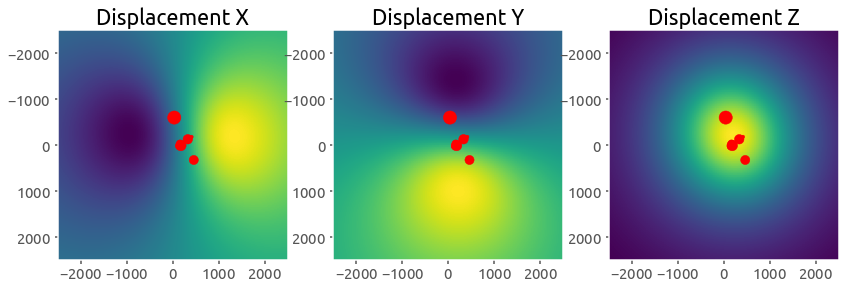

In [144]:
it = 800
fig,axes = plt.subplots(1, 3, figsize=(14,6))
im = axes[0].imshow(ux[:,:,it], extent=[-L/2,L/2,L/2,-L/2])
axes[0].set_title("Displacement X")
im = axes[1].imshow(uy[:,:,it], extent=[-L/2,L/2,L/2,-L/2])
axes[1].set_title("Displacement Y")
im = axes[2].imshow(uz[:,:,it], extent=[-L/2,L/2,L/2,-L/2])
axes[2].set_title("Displacement Z")

# Plot des chambres
for ax in axes:
    ax.grid(False)
    for mc in magma_chambers:
        ax.add_patch(plt.Circle((mc.x, mc.y), mc.radius, color='r'))

plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

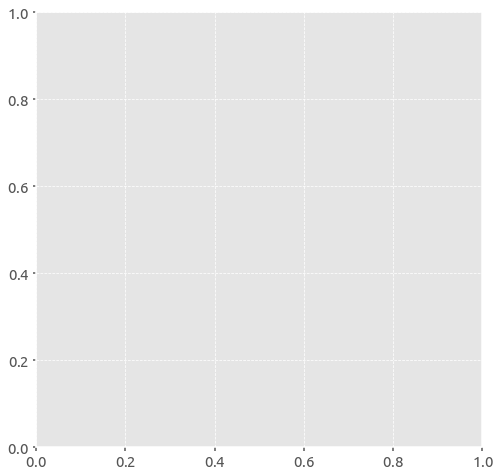

In [142]:
# Plot snapshot déplacement

scale_quiver = 2e-2

it = 800
fig,ax = plt.subplots(figsize=(8,8))

cf = ax.imshow(np.mod(uz[:,:,it],1e-3), extent=[-L/2,L/2,-L/2,L/2], cmap="hsv", interpolation="bilinear",interpolation_stage="rgba")
N_QUIVER = 4
ax.quiver(X[::N_QUIVER], Y[::N_QUIVER], ux[::N_QUIVER,::N_QUIVER,it], uy[::N_QUIVER,::N_QUIVER,it], scale=scale_quiver, color='k')

# Plot des chambres
def z_to_color(z):
    return [1-(z-Z_magma_body)/H_magma_body]*3

for mc in magma_chambers:
    ax.add_patch(plt.Circle((mc.x, mc.y), mc.radius, color=z_to_color(mc.z)))
    
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,pos : f"{x*1e-3:.0f} km"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos : f"{x*1e-3:.0f} km"))

# add magma chamber depth colormap
plt.colorbar(mpl.cm.ScalarMappable(
    norm = mpl.colors.Normalize(Z_magma_body, Z_magma_body+H_magma_body),
    cmap = "Greys"
    ),label = "Magma chamber depth (m)", shrink = 0.6)

# # add time info
# bbox_props = dict(boxstyle="round", facecolor="white", edgecolor="black", alpha=0.9)
# ax.annotate(f"At t={t_space[it]:.1f}s", (-110, 150),
#             textcoords="offset points", ha='center', va='center', bbox=bbox_props)



ax.grid(False)

plt.savefig("../figures/surface_deformation_it800.png",dpi=150)


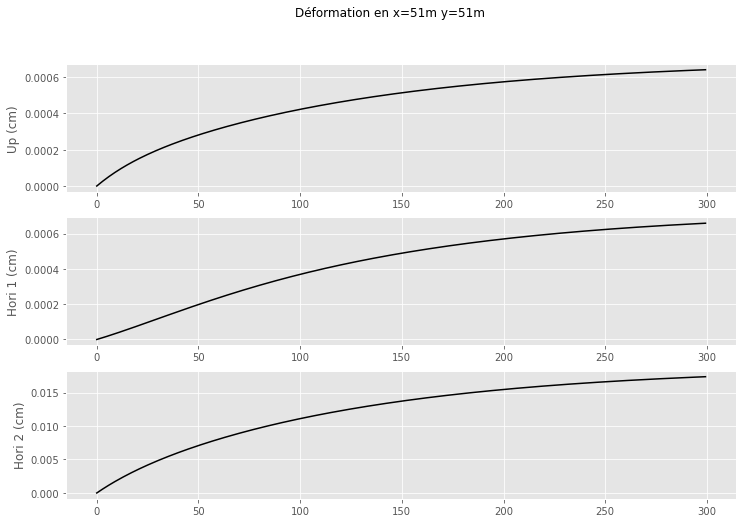

In [31]:
# Plot d'une timeserie de déplacement

x,y = N_space//2,N_space//2

Nt_max = 300

fig, ax = plt.subplots(3, 1, figsize=(12,8)) #figsize=plt.figaspect(1), dpi=200.)

for i,(cpnt,name) in enumerate(zip([ux,uy,uz],["Up (cm)","Hori 1 (cm)","Hori 2 (cm)"])):
    ax[i].plot(t_space[:Nt_max], cpnt[x,y,:Nt_max]*100 ,c="k")
    ax[i].set_ylabel(name)
    
fig.suptitle(f"Déformation en x={X[x]:.0f}m y={Y[y]:.0f}m")
plt.show()

Conclusion : impossible de faire la différence depuis les déplacements en surface entre une chambre unique et un ensemble de chambres

## Système de seuils d'activation sur les conductivités

In [37]:
# Système de seuil d'activation des conductivités

from pressure_timeseries import compute_pressure_time_serie_p_dep

DELTA_P = 1e7 # 10 MPa
def source(t, t_s=0.): return DELTA_P if t >= t_s else 0

tmax = 5e3 # 1 an
p0 = np.zeros(len(mc_graph)-1)

p2 = compute_pressure_time_serie_p_dep(mc_graph, source, tmax, p0, p_ts=1e5)

/home/sbrisson/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[]

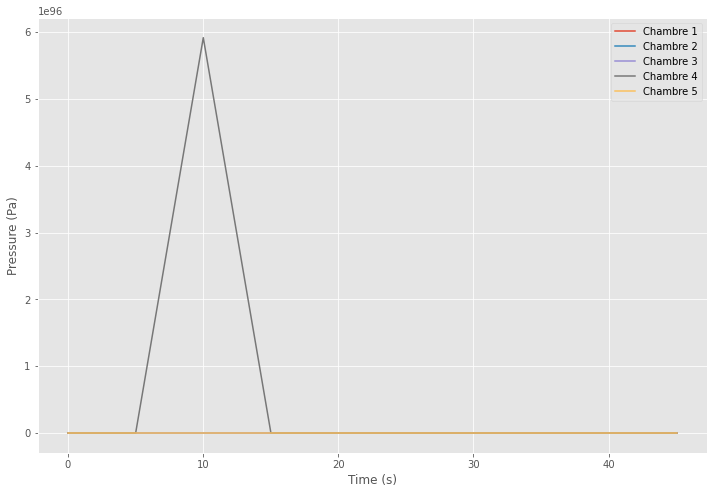

In [41]:
t_space = np.linspace(0, tmax, p.shape[0])
# plt.plot(t_space, [source(t_) for t_ in t_space], label="Source", color="k", ls=":")

N_tmax = 10

fig,ax = plt.subplots(figsize=(12,8))

for i in range(len(mc_graph)-1):
    ax.plot(t_space[:N_tmax], p2[:N_tmax,i], label=f"Chambre {i+1}")
    
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Pa)")
plt.legend()
plt.plot()

In [42]:
# plot movie
from matplotlib.animation import FuncAnimation

fig,axes = plt.subplots(1, 3, figsize=(14,6))

# get min/max
ux_min,ux_max = ux.min(),ux.max()
uy_min,uy_max = uy.min(),uy.max()
uz_min,uz_max = uz.min(),uz.max()

du = 1e-3

# plot
imx = axes[0].imshow(ux[:,:,0], cmap="hsv",interpolation="bilinear", interpolation_stage="rgba")
imy = axes[1].imshow(uy[:,:,0], cmap="hsv",interpolation="bilinear", interpolation_stage="rgba")
imz = axes[2].imshow(uz[:,:,0], cmap="hsv",interpolation="bilinear", interpolation_stage="rgba")

# updating function
di = 10
def updatefig(i):
    imx.set_array(np.mod(ux[:,:,i*di],du))
    imy.set_array(np.mod(uy[:,:,i*di],du))
    imz.set_array(np.mod(uz[:,:,i*di],du))
    # Adjust color limits
    imx.set_clim(0, du)
    imy.set_clim(0, du)
    imz.set_clim(0, du)
    
# animation
anim = FuncAnimation(fig, updatefig, interval=30, frames=(N_it-1)//di)

# save
anim.save("../figures/surface_deformation_franges_1kmdeep.mp4")


array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000],
       [ 1.20191601e+004,  7.15065047e+005,  2.47471035e+005,
         1.47471034e+005,  1.72763473e+004],
       [ 0.00000000e+000,  0.00000000e+000,  6.90033534e-310,
         5.91524946e+096,  6.90034219e-310],
       [-1.00652733e-111,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         6.90040115e-310, -3.37810118e-259],
       [ 6.90034025e-310,  2.97835558e-191,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  6.90040190e-310,  2.37517129e-288,
         0.00000000e+000,  0.00000000e+000],
       [ 6.90040001e-310,  1.75612040e-222,  0.00000000e+000,
         0.00000000e+000,  6.90037290e-310],
       [ 4.76999345e-146,  6.90034226